<a href="https://colab.research.google.com/github/gizdatalab/CPU/blob/main/Step5/CWIKI_Dataset_Finalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will normalize the dataset, final cleaning and refinement and give it a  final shape.

# Helper Functions

In [ ]:
# install language models from spacy
! python -m spacy download en_core_web_sm
! python -m spacy download fr_core_news_sm
! python -m spacy download es_core_news_sm

2024-01-06 09:11:35.882493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 09:11:35.882548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 09:11:35.884566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 09:11:35.896947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 09:11:37.989918: W tensorflow/compiler/tf2

In [ ]:
!pip install transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.9 MB/s eta 0:00:00


In [ ]:
import spacy
lang_to_spacymodel = {'en':'en_core_web_sm',
                      'fr':'fr_core_news_sm',
                      'es':'es_core_news_sm'
                      }

# load language models
spacy_model = {'en':spacy.load(lang_to_spacymodel['en']),
               'fr':spacy.load(lang_to_spacymodel['fr']),
               'es':spacy.load(lang_to_spacymodel['es'])
               }


import logging
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import _stop_words
import json

# mapping the iso language codes to nltk package nomemclature
iso639_to_nltk = {
    "ru": "russian",
    "sl": "slovene",
    "es": "spanish",
    "sv": "swedish",
    "tr": "turkish",
    "cs": "czech",
    "da": "danish",
    "nl": "dutch",
    "en": "english",
    "et": "estonian",
    "fi": "finnish",
    "fr": "french",
    "de": "german",
    "el": "greek",
    "it": "italian",
    "no": "norwegian",
    "pl": "polish",
    "pt": "portuguese",
    "ml": "malayalam",
}


def nltk_tokenize(text, language = 'en', removestopwords=False):
    """
    uses punkt tokenizer from nltk to tokenize based on language.
    languages supported by nltk are provided in is069 dictionary

    Params
    ------------------
    text: text to be tokenized
    langauge: language of text, used to determine which tokenizer to call for
    removestopwords: flag to inform if remove or keep the stopwords


    Returns
    ---------------
    tokenized_doc: Tokenized text

    """

    if language in iso639_to_nltk.keys():
        lang = iso639_to_nltk[language]
    else:
        logging.warning('langauge not found using English tokenizer and stopwords')
        lang = 'english'
    tokenslist = word_tokenize(text,language = lang)
    tokenized_doc = []
    # we can select to remove or keep stopwords
    if removestopwords == True:
        # stop words are fetched for particular language
        stop_words = stopwords.words(lang)
        for token in tokenslist:
            # remove the punctuations from word
            token = token.lower().strip(string.punctuation)
            if len(token) > 0 and token not in stop_words:
                tokenized_doc.append(token)
    else:
        for token in tokenslist:
            # remove the punctuations from word
            token = token.lower().strip(string.punctuation)
            if len(token) > 0:
                tokenized_doc.append(token)

    return tokenized_doc


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# We do some basic checks and add those statistics to datafrme for further actions
def get_match_percentage(string1, string2, lang, removestopwords =False):
    """
    Get the matching token between two strings. assumes the string1 is single string,
    but string2 is a list_of_strings. Uses the 'lang' to call relevant language
    tokenizer

    Params
    ------------------------
    string1: string which need to be searched for
    string2: list of strings in which string1 is searched. Remember we look for
              matching token between string1 and strings within list of string(string2)
    lang: language of the string1
    removestopwords: flag to inform if stop words should be considered as match or not


    Returns
    -------------------
    string1_wordcount: Word counts of string1
    string2_wordcount: wordcount of each string with the list
    matching_wordcount:List of Matching wordcount between string1 and list of strings
                      (string2)
    """
    # assumes the string1 is single string, but string2 is a list_of_strings
    # For each response we have 3 paragraphs provided by bm25 therefore we pass
    # string 2 as list of text.

    string1_words = nltk_tokenize(string1, lang, removestopwords=removestopwords)
    string2_words = []
    for i in string2:
        # print(i)
        string2_words.append(nltk_tokenize(i,lang, removestopwords=removestopwords))
    # collect matching words
    matching_words = []
    for i in string2_words:
        matching_words.append(set(string1_words) & set(i))

    string2_wordcount = [len(x) for x in string2_words]
    string1_wordcount = len(string1_words)
    matching_wordcount = [len(x) for x in matching_words]


    return (string1_wordcount, string2_wordcount, matching_wordcount)


In [ ]:
import string
def find_sub(context:str, candidate:str, find_all =False):
    """
    Find the candidate string within context. For the candidate string first strips
    any punctuations and then does the search. Further using the flag find_all, you
    can try to get index where the candidate string is present within context, this
    will provide all the index values, as candidate string can be present at multiple
    location.

    Params
    ---------------
    context:  The string in which the canidate string needs to be searched for
    candidate: the string which needs to be searched
    find_all: if should return the all index values of candidate string, If false
              just returns boolean True, False

    Returns
    -----------------
    temp: IF find_all = False, then temp will have boolean values True or False
          IF find-all = True, then temp will be list of index values

    """
    start = 0
    if find_all == False:
        val =  context.lower().find(candidate.strip(string.punctuation).lower(), start)
        if val != -1:
            temp = True
        else: temp = False
        return temp
    else:

        end = len(context)
        # print("candidate \n", candidate)
        # print(end)
        temp = []
        candidate_len = len(candidate.lower())
        while start < end -1:
            # print(start)
            val = context.lower().find(candidate.lower(), start)
            if val != -1:
                temp.append(val)
                start = val + candidate_len
            else:
                start = end
        return temp

## STEP1
import spacy
from spacy.matcher import Matcher, PhraseMatcher

def spacy_match(context:str, candidate:str, lang):
    """
    Find the list of tokens in candidate matching the tokens in context.
    For this we use the Spacy Pattern matcher especially using the 'Lemma' based
    matching.

    Params
    --------------------
    context: the string in which you want to find the matching list of tokens along
             with the indexes (string which needs to be searched into)
    candidate: the string which needs to searched for
    lang: Language of the strings (should be same). This is needed to call the
          language specific Spacy Matcher


    Returns
    -------------------
    spacy_doc: Return the context string as spacy doc (its a Spacy special class)
    matches(List[List]): indexes[start,end] list of matching tokens in context

    """
    nlp = spacy_model[lang]
    query_tokens = [token.lemma_.lower() for token in nlp(candidate)
                  if not (token.is_stop or token.is_punct)]
    # creating single token patterns to find using token list
    # this is requirement imposed by spacy
    patterns = [nlp(text) for text in query_tokens]

    # by experimentation it is seen that the best
    # strategy for now is to use Phrasematcher (and not Matcher)
    # and use attribute  = 'LEMMA'.
    matcher  = PhraseMatcher(nlp.vocab, attr="LEMMA")
    matcher.add("Terms", patterns)

    doc = nlp(context.lower())
    spacymatches = matcher(doc)

    # generating tokens list from spacy returned results
    matches = []
    for match_id, start, end in spacymatches:
        matches = matches + [[start, end]]

    spacy_doc = doc

    return (spacy_doc, matches)

def reduce(list_, response_length):
    """
    takes the list of tokens given from phrasematcher, and uses the stategies
    defined below to merge these token to create one continous string.
    There could be multiple candidate (answers) within a paragraph too.
    """
    merge_dist = min(7,response_length)
    candidates = []

    while len(list_)>1:
        # if the first two phrase are within the merge_dist, then merge them
        if list_[1][0] <list_[0][1]+merge_dist:
            start = list_[0][0]
            end = list_[1][1]
            # delete the first element
            list_.pop(0)
            # reset the [start, end] for new first element
            list_[0]= [start,end]
        else:
            # if merge fails, then the first element could itself be phrase
            # keeping minimum length of min(2,response_length) words for candidate.
            if (list_[0][1]-list_[0][0] >= min(2,response_length)):
                candidates.append(list_[0])
            list_.pop(0)
    # checking for last element left in list, if should be discarded or added as
    # candidate
    if len(list_) > 0:
        if list_[0][1] - list_[0][0] >1:
            candidates.append(list_[0])

    return candidates

def extract(index_list, spac_doc):
    # while we have answer start and end, we now  extract the actual text, which
    # could be used later for verification. This is done as it is not necessary
    # we get exact match but a part match (can happen due to annotator rephrasing
    # the response or other similar reasons)

    answers_list = []
    for j in  index_list:
        answers_list.append(spac_doc[j[0]:j[1]].text)
    return answers_list

# Normalize dataframe
In this subsection we will normalize the dataframe so that each row has similar flat structure. We need explode for Split_strategy and top_k ( for each strategy we have fetched top_k =3 best matching paragraphs/results)

In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# setting it to see full output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# we will need responses_context from step4
path_to_step4 = "/content/drive/MyDrive/Colab Notebooks/CPU/Step4/"
responses = pd.read_json(path_to_step4+"output/responses_context.json")
responses.drop(columns  = ['context_lang'], inplace=True) #'ResponseWordcount'
responses.rename(columns = {'language':'Language', 'context':'Context'},inplace=True)

In [ ]:
# some last check before we start answer extraction from context
print(len(responses))
remove = ['" (conditional)', '" (unconditional)', 'y, but Not Available',
                              '" (p. 30)','" (p. 9)','"ongoing"','and " (21)',]
responses['_textcheck'] = responses.ResponseText.apply(lambda x: True
                                                      if x in remove else False)
responses = responses[responses._textcheck == False].reset_index(drop=True)
responses.drop(columns = ['_textcheck'], inplace=True)
responses =  responses.reset_index(drop=True)
print(len(responses))

29762
29756


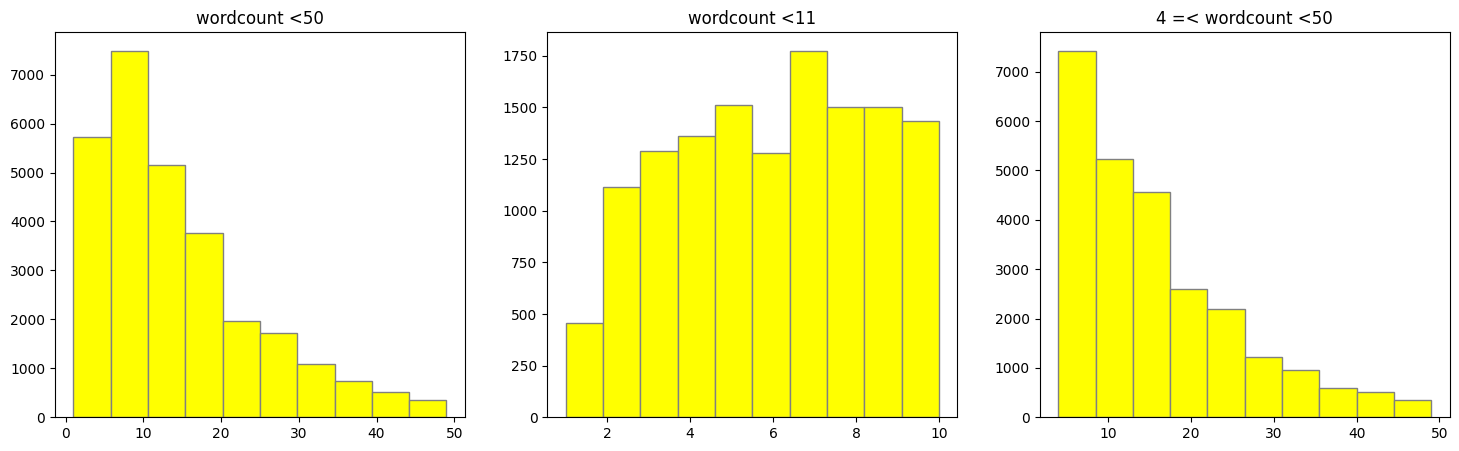

In [ ]:
# Response Wordcount distribution
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize = (18,5))
counts, bins, patches = ax[0].hist(responses[responses.ResponseWordcount<50]\
                          .ResponseWordcount, facecolor='yellow',edgecolor='gray')
ax[0].set_title('wordcount <50')

counts, bins, patches = ax[1].hist(responses[responses.ResponseWordcount<11]\
                          .ResponseWordcount, facecolor='yellow',edgecolor='gray')
ax[1].set_title('wordcount <11')
counts, bins, patches = ax[2].hist(responses[(responses.ResponseWordcount>=4)&
                            (responses.ResponseWordcount<50)].ResponseWordcount,
                                   facecolor='yellow',edgecolor='gray')
ax[2].set_title('4 =< wordcount <50')
plt.show()

In [ ]:
# make the copy for each split type
df_small = responses.copy()
df_medium =responses.copy()
df_large = responses.copy()
# keep the relevant Context list. We have 3 pair of keys and values.
# small, medium and large
df_small['Context']= df_small.Context.apply(lambda x: x['small'])
df_medium['Context']= df_medium.Context.apply(lambda x: x['medium'])
df_large['Context']= df_large.Context.apply(lambda x: x['large'])


# check if each subset has 3 paragraphs for each ResponseText or not
print("To be inspected row count",
      len(df_small[df_small.Context.apply(lambda x: len(x)) !=3]))
print("To be inspected row count",
      len(df_medium[df_medium.Context.apply(lambda x: len(x)) !=3]))
print("To be inspected row count",
    len(df_large[df_large.Context.apply(lambda x: len(x)) !=3]))

df_small['Strategy'] = 'small'
df_medium['Strategy'] = 'medium'
df_large['Strategy'] = 'large'

To be inspected row count 0
To be inspected row count 0
To be inspected row count 0


In [ ]:
# mereg back all dataframes, this is First step towards normalizing the dataframe.
responses = pd.concat([df_small, df_medium, df_large], ignore_index=True)
# we get the wordcount stats, this time we will ignore the stopwords
responses['ResponseWordcount'], responses['ContextWordcount'], responses['MatchingWordcount'] = \
                                                    zip(*responses.progress_apply(lambda x:
                    get_match_percentage(x['ResponseText'],x['Context'], x['Language'],
                                         removestopwords=True), axis =1))

In [ ]:
# We now apply second step towards normalization, whereby in each row we now have
# 1 context/paragraph only. However we need to be sure that which paragraph is
# top_k, therefore we pass that ranking in apply function below.
responses = (responses.explode(['Context','ContextWordcount','MatchingWordcount'])
       .groupby(level=0)
       .apply(lambda x: x.assign(top_k=[1,2,3]))
       .reset_index(drop=True))

In [ ]:
## save the results if you want
import json
path_to_step5 = "/content/drive/MyDrive/Colab Notebooks/CPU/Step5/"
jsonfile = responses.to_json(orient="records")
parsed = json.loads(jsonfile)
with open(path_to_step5 +'output/responses_normalized.json', 'w') as file:
    json.dump(parsed, file, indent=4)

# Paragraph Quality Assessment

In this sub-section we will revisit each row that is ResponseText and do the quality assessment of how much we are sure that ResponseText really belongs to Paragraph. Once we do this we will revisit the labels and make the necessary changes. Remember the Label right now are attached to ResponseText and not the
Paragraphs. The Label Finalization at Context level happens in next section

In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
path_to_step5 = "/content/drive/MyDrive/Colab Notebooks/CPU/Step5/"
responses = pd.read_json(path_to_step5 + 'output/responses_normalized.json')

In [ ]:
# getting Matching Percentage between Context and ResponseText
responses = responses[responses.ResponseWordcount>0].reset_index(drop=True)
responses['MatchOnResponse'] = responses.apply(lambda x:
                        round(x['MatchingWordcount']/x['ResponseWordcount'],2),
                                             axis=1)

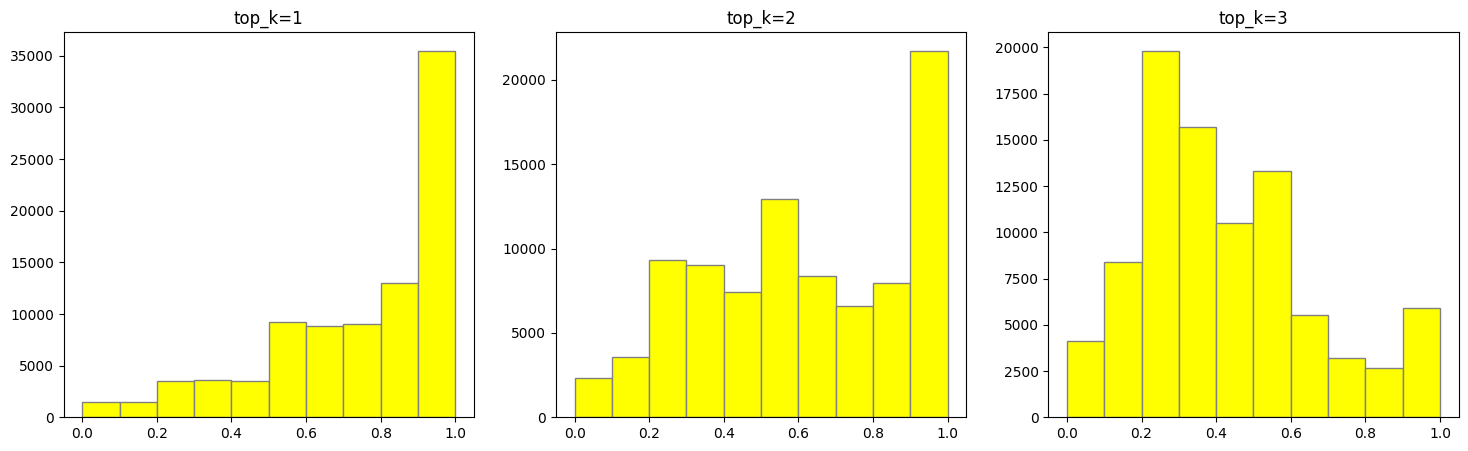

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize = (18,5))
counts, bins, patches = ax[0].hist(responses[responses.top_k == 1].MatchOnResponse,
                                   facecolor='yellow', edgecolor='gray')
ax[0].set_title('top_k=1')
counts, bins, patches = ax[1].hist(responses[responses.top_k == 2].MatchOnResponse,
                                   facecolor='yellow', edgecolor='gray')
ax[1].set_title('top_k=2')
counts, bins, patches = ax[2].hist(responses[responses.top_k == 3].MatchOnResponse,
                                   facecolor='yellow',edgecolor='gray')
ax[2].set_title('top_k=3')
plt.show()

In [ ]:
# we split the dataframe in two parts as ResponseText has wide Distribution.
df_small = responses[responses.ResponseWordcount < 4].reset_index(drop=True)
df_large = responses[responses.ResponseWordcount >= 4].reset_index(drop=True)
print(df_large.top_k.value_counts())
print(df_small.top_k.value_counts())

1    77865
2    77865
3    77865
Name: top_k, dtype: int64
1    11400
2    11400
3    11400
Name: top_k, dtype: int64


## Large ResponseText

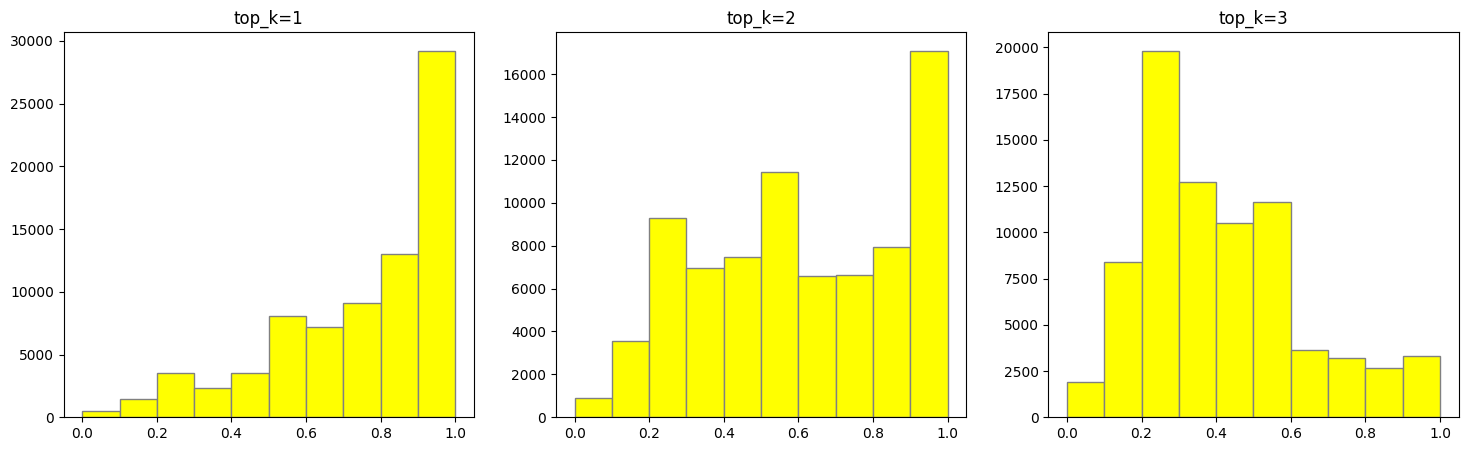

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,5))
counts, bins, patches = ax[0].hist(df_large[df_large.top_k == 1].MatchOnResponse,
                                   facecolor='yellow', edgecolor='gray')
ax[0].set_title('top_k=1')
counts, bins, patches = ax[1].hist(df_large[df_large.top_k == 2].MatchOnResponse,
                                   facecolor='yellow', edgecolor='gray')
ax[1].set_title('top_k=2')
counts, bins, patches = ax[2].hist(df_large[df_large.top_k == 3].MatchOnResponse,
                                   facecolor='yellow',edgecolor='gray')
ax[2].set_title('top_k=3')
plt.show()

In [ ]:
# for large strings we perform once the string match, because for string match we
# can be sure that paragraph really contains the response Text.
df_large['StringMatch'] = df_large.progress_apply(lambda x: find_sub(x['Context'],
                                                      x['ResponseText']),axis=1)

# checking some stats
print('\n',df_large.StringMatch.value_counts())

print('\n',df_large[df_large.StringMatch == True].top_k.value_counts())

100%|██████████| 233595/233595 [00:04<00:00, 51852.29it/s]


 False    193766
True      39829
Name: StringMatch, dtype: int64

 1    23603
2    14000
3     2226
Name: top_k, dtype: int64


In [ ]:
# separate out where String Match is possible. In other cases we will apply different
# technique.
df_large_1 = df_large[df_large.StringMatch == True].reset_index(drop=True)
df_large = df_large[df_large.StringMatch ==False].reset_index(drop=True)

63022 64245 66499


This part of code is compute intensive therefore you can break the dataset and loop through the parts. It has 3 steps.
1. Extract the Response token matching candidates within context (i.e not exact matching but 'Lemma' based and find its position within context.)
2. Merge and Reduce: Using the list of tokens extracted we, now merge these tokens list to find the candidate to 'ResponseText' within context ( only tokens indexes are used for this)
3. Extract the candidate phrase from context using indexes values from step 2.

In [ ]:
##### STEP 1: #####
# Getting the Matching token between Context and ResponseText along with
# indices[start,end] in context. The match is done on Lemma and not exact string
# match.
df_large['SpacyDoc'] , df_large['SpacyMatch'] = zip(*df_large.progress_apply(lambda x:
                                                    spacy_match(x['Context'],
                                      x['ResponseText'], x['Language']),axis=1))

##### STEP 2: #####
# From the previous step we try now the fuzzy merge of matching tokens to get the
# best matching span between Context and ResponseText
df_large['Candidate'] = df_large.apply(lambda x:
                        reduce(x['SpacyMatch'], x['ResponseWordcount']), axis=1)

##### STEP 3: #####
# Once the fuzzy matched spans indices[start,end] are doen from step 2, we
# get the actuall spans text.
df_large['FetchedText'] = df_large.apply(lambda x: extract(x['Candidate'],
                                                        x['SpacyDoc']),axis=1)

In [ ]:
# df1 = pd.read_json(path_to_step5+'output/Intermediate/df1_extracted.json')
# df2 = pd.read_json(path_to_step5+'output/Intermediate/df2_extracted.json')
# df3 = pd.read_json(path_to_step5+'output/Intermediate/df3_extracted.json')
# df_large_1 = pd.read_json(path_to_step5+'output/Intermediate/df_large_1.json')
# df_large = pd.concat([df1,df2,df3,df_large_1],ignore_index=True)

In [ ]:
# finally we label those Context as positive where we get either perfect
# String Match or there was text span which resembles the ResponseText
df_large['positive'] = df_large.apply(lambda x: True if x['StringMatch'] is True
                                    else (True if len(x['FetchedText']) > 0
                                          else False), axis=1)
# seprate out posiitve and negative
positive = df_large[df_large.positive == True].reset_index(drop=True)
negative = df_large[df_large.positive == False].reset_index(drop=True)

In [ ]:
# Performing some stats on the similar matching Text span from Context and ResponseText
positive['FetchedText'] = positive.apply(lambda x: x['FetchedText'] if
                                         x['StringMatch'] == False else
                                         [x['ResponseText']], axis=1)

positive['ResponseWord'], positive['CandidateWord'], positive['MatchWords'] = \
                    zip(*positive.progress_apply(lambda x:
                                        get_match_percentage(x['ResponseText'],
                                      x['FetchedText'], x['Language']),axis=1))

positive['CandidateMatchOnResponse'] = positive.apply(lambda x:
                                [round(j/x['ResponseWord'],2)
                                for j in x['MatchWords']],axis=1 )

100%|██████████| 201720/201720 [02:21<00:00, 1429.69it/s]


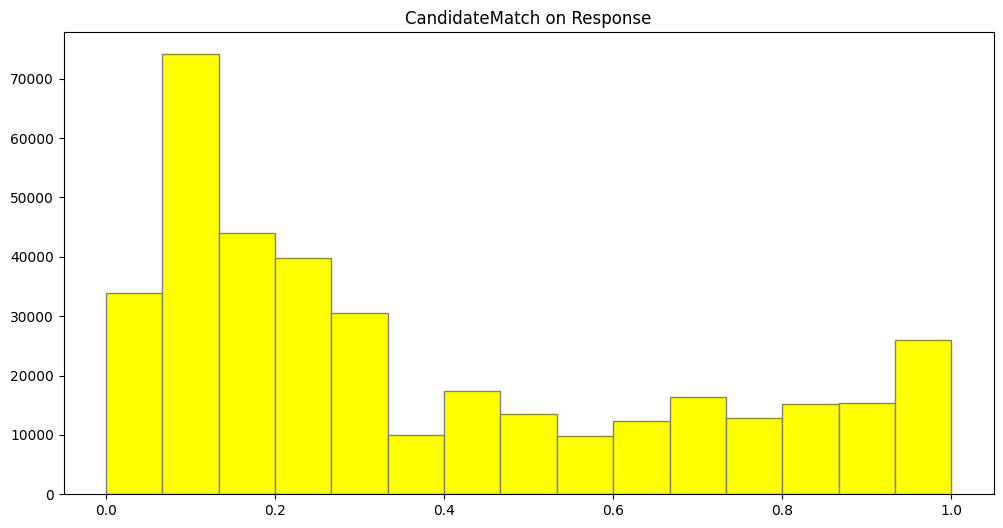

In [ ]:
# lets consider the Distribution of match percentage betweem ResponseText and
# Text Spans from Context
temp  = list(positive.CandidateMatchOnResponse)
flat_list = [item for sublist in temp for item in sublist]


import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize = (12,6))
counts, bins, patches = ax.hist(flat_list, facecolor='yellow',
                                                edgecolor='gray', bins = 15)
ax.set_title('CandidateMatch on Response')
plt.show()

In [ ]:
import numpy as np
# perform some checks based on Match Percentage, for ResponseWordcount > 10 words if
# more than 60% match is there and for words < 10 it should be 75%
positive['check'] = positive.apply(lambda x: any(np.array(x['CandidateMatchOnResponse'])> 0.75)
                                    if x['ResponseWordcount'] <10 else
                        any(np.array(x['CandidateMatchOnResponse'])> 0.6),axis=1)

positive.drop_duplicates(subset = ['ResponseText', 'Alpha3', 'Country', 'Document','Source',
                                'Target', 'Netzero', 'Adaptation', 'Mitigation',
       'GHG', 'Conditional', 'Unconditional', 'Language','Action',
       'Policies_Plans', 'Context', 'Strategy'], inplace=True)

# we apply some more check based on ResponseWordcount. In case ResponseText is more than
# 30 words and we dont find a match between Conetxt and Text spans from Context as done above
# then we can replace the Context with ResponseText
positive['check2'] = positive.apply(lambda x: (x['check'] == False)&(x['ResponseWordcount'] > 30),
                                                          axis=1)
positive['Context'] = positive.apply(lambda x: x['Context'] if x['check'] == True
                                     else x['ResponseText'] if x['check2'] == True
                                     else None, axis=1)

positive['MatchOnResponse'] = positive.apply(lambda x: x['MatchOnResponse'] if x['check'] == True
                                     else 1.0 if x['check2'] == True
                                     else None, axis=1)
positive['FetchedText'] = positive.apply(lambda x: x['FetchedText'] if x['check'] == True
                                     else [x['ResponseText']] if x['check2'] == True
                                     else None, axis=1)
positive['CandidateMatchOnResponse'] = positive.apply(lambda x: x['CandidateMatchOnResponse']
                                     if x['check'] == True
                                     else [1.0] if x['check2'] == True
                                     else None, axis=1)

positive.drop(columns = ['ResponseWordcount','ContextWordcount','MatchingWordcount',
                         'top_k', 'StringMatch','Candidate','ResponseWord',
                         'CandidateWord','MatchWords','check','check2'], inplace=True)
# Drop all non-relevant rows. We now have only enteries, where
# IF text span from Context match with ResponseText (>60% for wordcount >10, >75%
# for wordcount <=10), Further Where the ResponsetExt is moe=re than 30 words long
# we hae replaced the Context with ResponseText.
positive = positive[positive.Context.notna()]
positive = positive.reset_index(drop=True)

In [ ]:
# in negative we drop and the results if top_k =2 because for negative results we
# really want to be sure Context we are suing as negative exmamples for Text-Classiifcation
# doesnt have anything clsoely resembling the ResponseText.
negative = negative[negative.top_k == 3].reset_index(drop=True)
negative.drop(columns= ['ResponseWordcount','ContextWordcount','MatchingWordcount',
                          'top_k','MatchOnResponse', 'StringMatch', 'Candidate',
       'FetchedText'],inplace=True)
negative = negative.reset_index(drop=True)
negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17115 entries, 0 to 17114
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ResponseText    17115 non-null  object 
 1   Alpha3          17115 non-null  object 
 2   Country         17115 non-null  object 
 3   Document        17115 non-null  object 
 4   IkiInfo         1670 non-null   object 
 5   Source          17115 non-null  object 
 6   Target          17115 non-null  bool   
 7   Netzero         1670 non-null   float64
 8   Adaptation      17115 non-null  bool   
 9   Mitigation      17115 non-null  bool   
 10  GHG             108 non-null    float64
 11  Conditional     17115 non-null  bool   
 12  Unconditional   17115 non-null  bool   
 13  Language        17115 non-null  object 
 14  CWInfo          15445 non-null  object 
 15  Action          15445 non-null  float64
 16  Policies_Plans  15445 non-null  float64
 17  Context         17115 non-null 

In [ ]:
# merge back psoitive and negative results
df_large = pd.concat([positive,negative],ignore_index=True)
df_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111755 entries, 0 to 111754
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ResponseText              111755 non-null  object 
 1   Alpha3                    111755 non-null  object 
 2   Country                   111755 non-null  object 
 3   Document                  111755 non-null  object 
 4   IkiInfo                   15657 non-null   object 
 5   Source                    111755 non-null  object 
 6   Target                    111755 non-null  bool   
 7   Netzero                   15657 non-null   float64
 8   Adaptation                111755 non-null  bool   
 9   Mitigation                111755 non-null  bool   
 10  GHG                       1344 non-null    float64
 11  Conditional               111755 non-null  bool   
 12  Unconditional             111755 non-null  bool   
 13  Language                  111755 non-null  o

In [ ]:
# #save the results if you want
# import json
# jsonfile = df_large.to_json(orient="records")
# parsed = json.loads(jsonfile)
# with open(path_to_step5+ 'output/df_large.json', 'w') as file:
#     json.dump(parsed, file, indent=4)

## Small Response Text


We repeat the similar steps like in subsection Large Response Text.

In [ ]:
# perform the simple string search
df_small['StringMatch'] = df_small.progress_apply(lambda x: find_sub(x['Context'],
                                                      x['ResponseText']),axis=1)

# checking some stats
print('\n',df_small.StringMatch.value_counts())
print('\n',df_small[df_small.StringMatch == True].top_k.value_counts())

100%|██████████| 34200/34200 [00:00<00:00, 62508.45it/s]


 False    24464
True      9736
Name: StringMatch, dtype: int64

 1    4607
2    3363
3    1766
Name: top_k, dtype: int64


In [ ]:
# separate out the two categories
df_small_1 = df_small[df_small.StringMatch == True].reset_index(drop=True)
df_small = df_small[df_small.StringMatch ==False].reset_index(drop=True)

In [ ]:
##### STEP 1: #####
# Getting the Matching token between Context and ResponseText along with
# indices[start,end] in context. The match is done on Lemma and not exact string
# match.
df_small['SpacyDoc'] , df_small['SpacyMatch'] = zip(*df_small.progress_apply(lambda x:
                                                    spacy_match(x['Context'],
                                      x['ResponseText'], x['Language']),axis=1))

##### STEP 2: #####
# From the previous step we try now the fuzzy merge of matching tokens to get the
# best matching span between Context and ResponseText
df_small['Candidate'] = df_small.apply(lambda x:
                        reduce(x['SpacyMatch'], x['ResponseWordcount']), axis=1)

##### STEP 3: #####
# Once the fuzzy matched spans indices[start,end] are doen from step 2, we
# get the actuall spans text.
df_small['FetchedText'] = df_small.apply(lambda x: extract(x['Candidate'],
                                                        x['SpacyDoc']),axis=1)

100%|██████████| 24464/24464 [23:35<00:00, 17.29it/s]


In [ ]:
df_small.drop(columns = ['SpacyDoc','SpacyMatch'], inplace=True)
# merge the String Match results with original dataframe
df_small = pd.concat([df_small, df_small_1],ignore_index=True)

In [ ]:
# df1 = pd.read_json(path_to_step5+'output/Intermediate/df_small_1.json')
# df2 = pd.read_json(path_to_step5+'output/Intermediate/df_small.json')
# df_small = pd.concat([df1,df2],ignore_index=True)

In [ ]:
# seprate out positive canidate where we are getitng some Text Span from Context
# with ResponseText
df_small['positive'] = df_small.apply(lambda x: True if x['StringMatch'] is True
                                    else (True if len(x['FetchedText']) > 0
                                          else False), axis=1)

positive = df_small[df_small.positive == True].reset_index(drop=True)
negative = df_small[df_small.positive == False].reset_index(drop=True)

In [ ]:
# performing some stats
positive['FetchedText'] = positive.apply(lambda x: x['FetchedText'] if
                                         x['StringMatch'] == False else
                                         [x['ResponseText']], axis=1)

positive['ResponseWord'], positive['CandidateWord'], positive['MatchWords'] = \
                    zip(*positive.progress_apply(lambda x:
                                        get_match_percentage(x['ResponseText'],
                                      x['FetchedText'], x['Language']),axis=1))


positive['CandidateMatchOnResponse'] = positive.apply(lambda x:
                                [round(j/x['ResponseWord'],2)
                                for j in x['MatchWords']],axis=1 )

100%|██████████| 15357/15357 [00:07<00:00, 2187.56it/s]


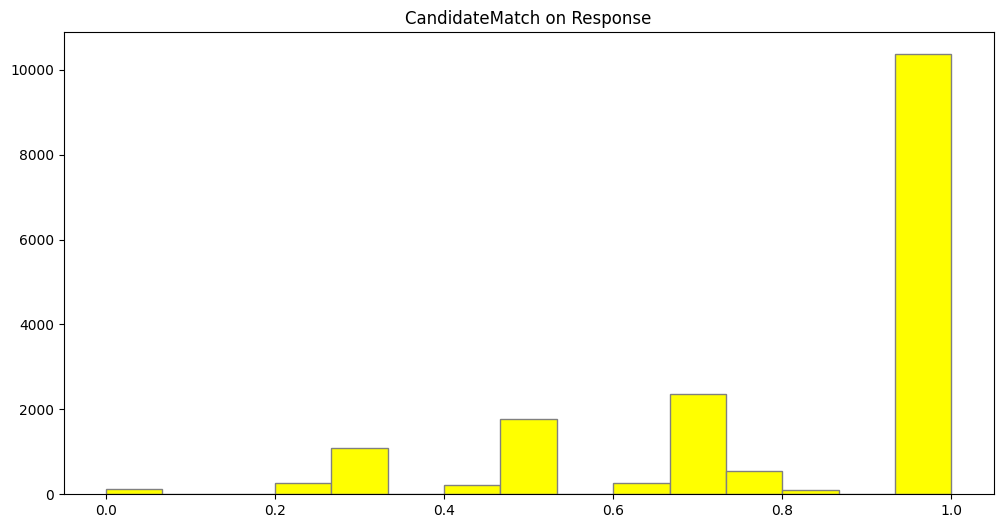

In [ ]:
# plot the matching percentage
temp  = list(positive.CandidateMatchOnResponse)
flat_list = [item for sublist in temp for item in sublist]


import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize = (12,6))
counts, bins, patches = ax.hist(flat_list, facecolor='yellow',
                                                edgecolor='gray', bins = 15)
ax.set_title('CandidateMatch on Response')
plt.show()

In [ ]:
import numpy as np
# We will consider positive example only if match percentage > 90%
positive['check'] = positive.apply(lambda x: any(np.array(x['CandidateMatchOnResponse'])> 0.9)
                                                                        ,axis=1)

positive.drop_duplicates(subset = ['ResponseText', 'Alpha3', 'Country', 'Document','Source',
                                'Target', 'Netzero', 'Adaptation', 'Mitigation',
       'GHG', 'Conditional', 'Unconditional', 'Language','Action',
       'Policies_Plans', 'Context', 'Strategy'], inplace=True)
positive = positive[positive.check==True].reset_index(drop=True)
positive.drop(columns = ['ResponseWordcount','ContextWordcount','MatchingWordcount',
                         'top_k', 'StringMatch','Candidate','ResponseWord',
                         'CandidateWord','MatchWords','check'], inplace=True)
positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10327 entries, 0 to 10326
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ResponseText              10327 non-null  object 
 1   Alpha3                    10327 non-null  object 
 2   Country                   10327 non-null  object 
 3   Document                  10327 non-null  object 
 4   IkiInfo                   485 non-null    object 
 5   Source                    10327 non-null  object 
 6   Target                    10327 non-null  bool   
 7   Netzero                   485 non-null    float64
 8   Adaptation                10327 non-null  bool   
 9   Mitigation                10327 non-null  bool   
 10  GHG                       0 non-null      float64
 11  Conditional               10327 non-null  bool   
 12  Unconditional             10327 non-null  bool   
 13  Language                  10327 non-null  object 
 14  CWInfo

In [ ]:
# in negative we drop and the results if top_k =2 because for negative results we
# really want to be sure Context we are suing as negative exmamples for Text-Classiifcation
# doesnt have anything clsoely resembling the ResponseText.

negative = negative[negative.top_k == 3].reset_index(drop=True)
negative.drop(columns= ['ResponseWordcount','ContextWordcount','MatchingWordcount',
                          'top_k','MatchOnResponse', 'StringMatch', 'Candidate',
       'FetchedText'],inplace=True)
negative = negative.reset_index(drop=True)
negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7974 entries, 0 to 7973
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ResponseText    7974 non-null   object 
 1   Alpha3          7974 non-null   object 
 2   Country         7974 non-null   object 
 3   Document        7974 non-null   object 
 4   IkiInfo         346 non-null    object 
 5   Source          7974 non-null   object 
 6   Target          7974 non-null   bool   
 7   Netzero         346 non-null    float64
 8   Adaptation      7974 non-null   bool   
 9   Mitigation      7974 non-null   bool   
 10  GHG             12 non-null     float64
 11  Conditional     7974 non-null   bool   
 12  Unconditional   7974 non-null   bool   
 13  Language        7974 non-null   object 
 14  CWInfo          7628 non-null   object 
 15  Action          7628 non-null   float64
 16  Policies_Plans  7628 non-null   float64
 17  Context         7974 non-null   o

In [ ]:
df_small = pd.concat([positive,negative],ignore_index=True)
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18301 entries, 0 to 18300
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ResponseText              18301 non-null  object 
 1   Alpha3                    18301 non-null  object 
 2   Country                   18301 non-null  object 
 3   Document                  18301 non-null  object 
 4   IkiInfo                   831 non-null    object 
 5   Source                    18301 non-null  object 
 6   Target                    18301 non-null  bool   
 7   Netzero                   831 non-null    float64
 8   Adaptation                18301 non-null  bool   
 9   Mitigation                18301 non-null  bool   
 10  GHG                       12 non-null     float64
 11  Conditional               18301 non-null  bool   
 12  Unconditional             18301 non-null  bool   
 13  Language                  18301 non-null  object 
 14  CWInfo

In [ ]:
# #save the results if you want
# import json
# jsonfile = df_small.to_json(orient="records")
# parsed = json.loads(jsonfile)
# with open(path_to_step5+ 'output/df_small.json', 'w') as file:
#     json.dump(parsed, file, indent=4)

# Labels Finalization

In this section we build on Labels using the Question Definition. Analysis reveals that Question definition is better suited for Labelling and its more graular than QuestionText

In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
path_to_step5 = "/content/drive/MyDrive/Colab Notebooks/CPU/Step5/"
df_large = pd.read_json(path_to_step5+'output/df_large.json')
df_small = pd.read_json(path_to_step5+'output/df_small.json')
df_small['check'] = 'small'
df_large['check'] = 'large'
df = pd.concat([df_small,df_large], ignore_index=True)

In the review it is seen that the negative examples are not actually true negative examples becuase for example the paragraph might contain target information but it is not pertaining to the Sector that is being tagged and hence does not serve the purpose of providing with negative examples. For this reason We will drop the negative examples

In [ ]:
# separate out the dataset
# filter out negative examples by the flag, for reason mentioned
# above.
df = df[df.positive == True]
cw_data = df[df.Source == 'CW'].reset_index(drop=True)
print(len(cw_data))
iki_data = df[df.Source == 'IKITracs'].reset_index(drop=True)
print(len(iki_data))

90495
14472


## CW

In [ ]:
def compress_info(response, matchingtext,info):
    """
    We add the ResponseText and Matching Text from Context to CwInfo to keep it
    all in one place

    """
    for i in info:
            i['ResponseText'] = response
            i['MatchingSpanFromContext']= matchingtext
    return info

In [ ]:
cw_data['CWInfo'] = cw_data.apply(lambda x: compress_info(x['ResponseText'],
                                                          x['FetchedText'],
                                                          x['CWInfo']),axis=1)

In [ ]:
# Definining Labels based on 'QuestionDefinition', this build on top of Question Text
# and aligns it very close to CW taxonomy and allows to tap into Adaptation OverviewCategory
# for finding the subcategories

targets_type_question_definition = ['Measurable targets or indicators',
                                    'Targets at the sectoral level',
    'Conditional part of mitigation target for a given sectoral downstream actions',
    'Unconditional part of mitigation target for a given sectoral downstream action',
    'Conditional part of mitigation target for a given sectoral upstream policy',
    'Unconditional part of the mitigation effort for a given sectoral target',
    'Conditional part of the mitigation target for a given sectoral target',
    'emission reduction potential for a given sectoral target',
    'Adaptation targets/ objectives at the sectoral level',
    'Unconditional part of mitigation target for a given sectoral plan',
    'Unconditional part of mitigation target for a given upstream sectoral policy',
    'Conditional part of mitigation target for a given sectoral plan',]


actions_type_question_definition = ['Adaptation action/priority',
    'Emission reduction potential for a given sectoral downstream action',
    'Conditional part of mitigation target for a given sectoral downstream actions',
    'Condition actions of the sectoral level',
    'Unconditional part of mitigation target for a given sectoral downstream action',
    'Existing sectoral downstream actions that the NDC builds on',
    'Sectoral downstream actions to be undertaken as part of the NDC contribution',
    'Unconditional sectoral actions',]


policies_type_question_definition = ['Sectoral plans and strategies for adaptation.',
    'Conditional part of mitigation target for a given sectoral upstream policy',
    'Information on the existing upstream sectoral policies that the NDC builds on',
    'Information on upstream policies for a given sector',
    'Whether the upstream policy in the given sector builds on NAMA',
    'Unconditional part of mitigation target for a given upstream sectoral policy',
    'Emission reduction potential for a given sectoral upstream',]


plans_type_question_definition = ['Sectoral plans and strategies for adaptation.',
    'Information on sectoral plans',
    'emission reduction potential for a given sectoral plan',
    'Unconditional part of mitigation target for a given sectoral plan',
    'Conditional part of mitigation target for a given sectoral plan',]


conditional_type_question_definition = ['Condition actions of the sectoral level',
    'Conditional part of mitigation target for a given sectoral downstream actions',
    'Conditional part of mitigation target for a given sectoral upstream policy',
    'Conditional part of the mitigation target for a given sectoral target',
    'Conditional part of mitigation target for a given sectoral plan',
    'The agency responsible for implementing the sectoral conditional action',
    'The funders for sectoral unconditional actions',]


unconditional_type_question_definition = ['Unconditional sectoral actions',
    'Unconditional part of mitigation target for a given sectoral downstream action',
    'Unconditional part of the mitigation effort for a given sectoral target',
    'Unconditional part of mitigation target for a given sectoral plan',
    'Unconditional part of mitigation target for a given upstream sectoral policy',
    'The agency responsible for implementing the sectoral unconditional actions',
    'The funders for sectoral unconditional actions'   ]

adaptation_type_OverviewCategory = ['Adaptation Commitments']

mitigation_type_OverviewCategory = ['Sectoral Mitigation Actions',
                                    'Sectoral Mitigation Targets',
                                    'Sectoral Mitigation Plans',
                                    'Sectoral Mitigation Policies']

In [ ]:
# cw_data.drop(columns = ['Target', 'Netzero', 'Adaptation', 'Mitigation', 'GHG',
#                         'Conditional','Unconditional', 'Action', 'Policies_Plans',
#                         'IkiInfo','ResponseText','FetchedText','MatchOnResponse',
#                         'CandidateMatchOnResponse','check','positive'],
#                          inplace=True)

### Groupby Context

We start the grouping of Context. So far we have each responsetext from CW and
attached the Context to this responsetext. The labels are attached with ResponseText, but now we need to apply the labels to the Context.

- Step1: Groupby the Context (keep startegy separately)
- Step2: Apply labels at Context level now.

In [ ]:
# split dataset by strategy
df_small = cw_data[cw_data.Strategy == 'small']
df_medium = cw_data[cw_data.Strategy == 'medium']
df_large = cw_data[cw_data.Strategy == 'large']

# apply the groupby, we collect all information as set or list depending on kind of
# variable
df_small = df_small.groupby(['Context','Alpha3'], as_index = False)\
                    .agg({'Country':set,'Document':set,'Language':set,
                           'CWInfo':list})

df_medium = df_medium.groupby(['Context','Alpha3'], as_index = False)\
                    .agg({'Country':set,'Document':set,'Language':set,
                       'CWInfo':list})

df_large = df_large.groupby(['Context','Alpha3'], as_index = False)\
                    .agg({'Country':set,'Document':set,'Language':set,
                           'CWInfo':list})

In [ ]:
# Extract the  CW info, we pass the field name whcih need to be extacted from CWInfo
def cw_extract_info(infolist,var):
    return list(set([i[var].strip() for i in infolist]))

# Helper functions to work with Groupby aggregated values
def check_noneandempty(x):
    if x is not None:
        if (len(x) !=0):
          return True
    return False

def flatten(x):
    """
    check if the empty list, if not then will flatten the list of list"""
    temp = []
    if check_noneandempty(x):
      for sublist in x:
          if check_noneandempty(sublist):
            for item in sublist:
                temp.append(item)
    return temp

def df_harmonize(df):
    """
    given the cw dataframe we get all the necessary information as columns
    and at same time using the helper functions make the aggregated values

    """
    df['Country'] = df.Country.apply(lambda x: list(x)[0])
    df['Language'] = df.Language.apply(lambda x: list(x)[0])
    df['Document'] = df.Document.apply(lambda x: list(x))
    df['CWInfo'] = df.CWInfo.apply(lambda x: flatten(x))
    df['Sector'] = df.apply(lambda x: cw_extract_info(x['CWInfo'],'Sector'),axis=1)
    df['SubSector'] = df.apply(lambda x: cw_extract_info(x['CWInfo'],'SubSector'),axis=1)
    df['OverviewCategory'] = df.apply(lambda x: cw_extract_info(x['CWInfo'],
                                                    'OverviewCategory'),axis=1)
    df['QuestionText'] = df.apply(lambda x: cw_extract_info(x['CWInfo'],
                                                            'QuestionText'),axis=1)
    df['QuestionDefinition'] = df.apply(lambda x: cw_extract_info(x['CWInfo'],
                                                      'QuestionDefinition'),axis=1)
    return df

In [ ]:
# Normalize the dataframe by getting all important CW information as columns
df_small = df_harmonize(df_small)
df_medium = df_harmonize(df_medium)
df_large = df_harmonize(df_large)

df_small['Strategy'] = 'small'
df_medium['Strategy'] = 'medium'
df_large['Strategy'] = 'large'

cw_data = pd.concat([df_large,df_medium,df_small],ignore_index=True)

In [ ]:
# method to get the labels value
def labels_check(list1,checkin):
    return any([True if i in checkin else False for i in list1])


In [ ]:
# extract the labels information at Context level
cw_data['TargetLabel'] = cw_data.apply(lambda x: labels_check(x['QuestionDefinition'],
                                          targets_type_question_definition),axis=1)
cw_data['ActionLabel'] = cw_data.apply(lambda x: labels_check(x['QuestionDefinition'],
                                          actions_type_question_definition),axis=1)
cw_data['PolicyLabel'] = cw_data.apply(lambda x: labels_check(x['QuestionDefinition'],
                                          policies_type_question_definition),axis=1)
cw_data['PlansLabel'] = cw_data.apply(lambda x: labels_check(x['QuestionDefinition'],
                                          plans_type_question_definition),axis=1)
cw_data['ConditionalLabel'] = cw_data.apply(lambda x: labels_check(x['QuestionDefinition'],
                                          conditional_type_question_definition),axis=1)
cw_data['UnconditionalLabel'] = cw_data.apply(lambda x: labels_check(x['QuestionDefinition'],
                                          unconditional_type_question_definition),axis=1)
cw_data['AdaptationLabel'] = cw_data.apply(lambda x: labels_check(x['OverviewCategory'],
                                          adaptation_type_OverviewCategory),axis=1)
cw_data['MitigationLabel'] = cw_data.apply(lambda x: labels_check(x['OverviewCategory'],
                                          mitigation_type_OverviewCategory),axis=1)

In [ ]:
temp = list(cw_data.QuestionDefinition)
question_definition_list = set([item for sublist in temp for item in sublist])

remaining_ques = question_definition_list - (set(targets_type_question_definition).union(
                                      actions_type_question_definition,
                                      plans_type_question_definition,
                                      policies_type_question_definition,
                                      conditional_type_question_definition,
                                      unconditional_type_question_definition))
remaining_ques

{'Capacity building needed for a given sectoral downstream action',
 'Capacity building needed for a given sectoral plan',
 'Capacity building needed for a given sectoral target',
 'Capacity building needed for a given sectoral upstream policy',
 'Capacity building needs for Sectoral implementation',
 'GCA_Sector',
 'GCA_Sector_2',
 'GCA_Sector_3',
 'Information on how progress for sectoral implementation will be tracked',
 'Information on progress towards a given sectoral target',
 'Technology needed for a given sectoral downstream action',
 'Technology needed for a given sectoral plan',
 'Technology needed for a given sectoral target',
 'Technology needed for a given sectoral upstream policy',
 'Technology transfer needs for sectoral implementation',
 'The funders for sectoral conditional actions',
 'Time frame'}

In [ ]:
# We have the labels, in some cases the 'False' Label does not represent the ground
# truth. If sme question category is not assigned to the text it does not mean
# that that category is not present. The way to insure that this does not happen
# we will use the 'OVerviewCategory' to in some cases to make entries as
# non-applicable to those labels by assigning them None value.

# For Target, Action, Policy and Plans, we use 'OverviewCategory' to define None.
# Ex: We have TargetLabel == False, because none of the Questiondefinition which identify
# 'Target' is present. However in Overviewcategory we still have 'Sectoral Mitigaton Target'.
# in this case we will discard this entry and make TargetLabel == None, because this
# cannot be ascertained as False example for TargetLabel.

cw_data['TargetLabel'] = cw_data.apply(lambda x: True
                              if (x['TargetLabel'] == True)
                              else False if
                             ('Sectoral Mitigation Targets'
                              not in x['OverviewCategory']) else None, axis=1)


cw_data['ActionLabel'] = cw_data.apply(lambda x: True
                              if (x['ActionLabel'] == True)
                              else False if
                             ('Sectoral Mitigation Actions'
                              not in x['OverviewCategory']) else None, axis=1)

cw_data['PolicyLabel'] = cw_data.apply(lambda x: True
                              if (x['PolicyLabel'] == True)
                              else False if
                              ('Sectoral Mitigation Policies'
                              not in x['OverviewCategory']) else None, axis=1)

cw_data['PlansLabel'] = cw_data.apply(lambda x: True
                              if (x['PlansLabel'] == True)
                              else False if
                             ('Sectoral Mitigation Planss'
                              not in x['OverviewCategory']) else None, axis=1)

cw_data['AdaptationLabel'] = cw_data.apply(lambda x: True
                              if (x['AdaptationLabel'] == True)
                              else False if
                              ('Adaptation Commitments'
                              not in x['OverviewCategory']) else None, axis=1)
cw_data['MitigationLabel'] = cw_data.apply(lambda x: True
                              if (x['MitigationLabel'] == True)
                              else False if
                             ('Mitigation'
                              not in str(x['OverviewCategory'])) else None, axis=1)

# for conditionality and Unconditionality are kept as independent and anything which doesnt
# belong to Conditonality QuestionDefinition category will go into False. Similar
# is case for Unconditionality
# cw_data['ConditionalLabel'] = cw_data.apply(lambda x: True
#                               if ((x['ConditionalLabel'] == True)&(x['positive'] ==True))
#                               else False, axis=1)

# cw_data['UnconditionalLabel'] = cw_data.apply(lambda x: True
#                               if ((x['UnconditionalLabel'] == True)&(x['positive'] ==True))
#                               else False, axis=1)

In [ ]:
cw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33314 entries, 0 to 33313
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Context             33314 non-null  object
 1   Alpha3              33314 non-null  object
 2   Country             33314 non-null  object
 3   Document            33314 non-null  object
 4   Language            33314 non-null  object
 5   CWInfo              33314 non-null  object
 6   Sector              33314 non-null  object
 7   SubSector           33314 non-null  object
 8   OverviewCategory    33314 non-null  object
 9   QuestionText        33314 non-null  object
 10  QuestionDefinition  33314 non-null  object
 11  Strategy            33314 non-null  object
 12  TargetLabel         33195 non-null  object
 13  ActionLabel         33229 non-null  object
 14  PolicyLabel         33220 non-null  object
 15  PlansLabel          33314 non-null  bool  
 16  ConditionalLabel    33

In [ ]:
# method to get the count of each Label Category, revealing how many
# True, False and None category we have
def boolvalidate(data, col):
    print('Total count', len(data))
    print('{} count'.format(col), sum(data[col] == True),
          'Non {} count'.format(col), sum(data[col]==False))
    print('Missig values', sum(data[col].isna()))

In [ ]:
boolvalidate(cw_data[cw_data.Strategy == 'medium'],'TargetLabel')
boolvalidate(cw_data[cw_data.Strategy == 'medium'],'ActionLabel')
boolvalidate(cw_data[cw_data.Strategy == 'medium'],'PolicyLabel')
boolvalidate(cw_data[cw_data.Strategy == 'medium'],'PlansLabel')
boolvalidate(cw_data[cw_data.Strategy == 'medium'],'ConditionalLabel')
boolvalidate(cw_data[cw_data.Strategy == 'medium'],'UnconditionalLabel')
boolvalidate(cw_data[cw_data.Strategy == 'medium'],'AdaptationLabel')
boolvalidate(cw_data[cw_data.Strategy == 'medium'],'MitigationLabel')

Total count 11484
TargetLabel count 3298 Non TargetLabel count 8143
Missig values 43
Total count 11484
ActionLabel count 6176 Non ActionLabel count 5278
Missig values 30
Total count 11484
PolicyLabel count 1581 Non PolicyLabel count 9874
Missig values 29
Total count 11484
PlansLabel count 2446 Non PlansLabel count 9038
Missig values 0
Total count 11484
ConditionalLabel count 2071 Non ConditionalLabel count 9413
Missig values 0
Total count 11484
UnconditionalLabel count 974 Non UnconditionalLabel count 10510
Missig values 0
Total count 11484
AdaptationLabel count 5876 Non AdaptationLabel count 5608
Missig values 0
Total count 11484
MitigationLabel count 6006 Non MitigationLabel count 5478
Missig values 0


In [ ]:
cw_data.rename(columns = {'OverviewCategory':'CW_OverviewCategory',
                          'QuestionText':'CW_QuestionText',
                          'QuestionDefinition':'CW_QuestionDefinition',
                          }, inplace=True)

## IKI

In [ ]:
# similar to CW data we apply the ResposneText and Matching text span from Context
# transformation to ikidata
iki_data['IkiInfo'] = iki_data.apply(lambda x: compress_info(x['ResponseText'],
                                                          x['FetchedText'],
                                                          x['IkiInfo']),axis=1)

In [ ]:
# defining the labelling criterea for categories
netzero_ikisheet = ['netzero']
target_ikisheet = ['netzero', 'targets']
ghg_yes_ikiparameter = ['T_Transport_Unc','T_Transport_C']
ghg_no_ikiparameter = ['T_Adaptation_Unc', 'T_Adaptation_C', 'T_Transport_O_Unc',
                                      'T_Transport_O_C']

# mitigation and adaptation willneed both Sheet info and Paramter info
mitigation_ikiparameter = ['T_Transport_O_Unc',
                           'T_Transport_Unc',
                           'T_Transport_C'
                           'T_Transport_O_C']
mitigation_ikisheet = ['mitigation']
adaptation_ikiparameter = ['T_Adaptation_Unc', 'T_Adaptation_C']
adaptation_ikisheet = ['adaptation']

conditional_ikiparameter = ['T_Netzero_C',
                            'T_Economy_C',
                            'T_Transport_O_C',
                            'T_Adaptation_C',
                            'T_Transport_C',
                            'M_Volume_c']
unconditional_ikiparameter = ['T_Transport_O_Unc',
                              'T_Economy_Unc',
                              'T_Transport_Unc',
                              'T_Adaptation_Unc',
                              'M_Volume_unc']

### Groupby Context

In [ ]:
# split datasrt by Strategy
df_small = iki_data[iki_data.Strategy == 'small']
df_medium = iki_data[iki_data.Strategy == 'medium']
df_large = iki_data[iki_data.Strategy == 'large']

# apply groupby
df_small = df_small.groupby(['Context','Alpha3'], as_index = False)\
                    .agg({'Country':set,'Document':set,'Language':set,
                          'IkiInfo':list})

df_medium = df_medium.groupby(['Context','Alpha3'], as_index = False)\
                    .agg({'Country':set,'Document':set,'Language':set,
                          'IkiInfo':list})

df_large = df_large.groupby(['Context','Alpha3'], as_index = False)\
                    .agg({'Country':set,'Document':set,'Language':set,
                          'IkiInfo':list})

In [ ]:
# Extract the  IKI info, we apss the field anme whcih need to be extacted from CWInfo
def iki_extract_info(infolist,var):
    return list(set([i[var] for i in infolist]))


def df_harmonize_iki(df):
    """
    given the cw dataframe we get all the necessary information as columns
    and at same time using the helper functions make the aggregated values
    readable

    """
    df['Country'] = df.Country.apply(lambda x: list(x)[0])
    df['Language'] = df.Language.apply(lambda x: list(x)[0])
    df['Document'] = df.Document.apply(lambda x: list(x))
    df['IkiInfo'] = df.IkiInfo.apply(lambda x: flatten(x))
    df['IkiSheet'] = df.apply(lambda x: iki_extract_info(x['IkiInfo'],'IkiSheet'),axis=1)
    df['Parameter'] = df.apply(lambda x: iki_extract_info(x['IkiInfo'],'parameter'),axis=1)
    return df

In [ ]:
df_small = df_harmonize_iki(df_small)
df_medium = df_harmonize_iki(df_medium)
df_large = df_harmonize_iki(df_large)

df_small['Strategy'] = 'small'
df_medium['Strategy'] = 'medium'
df_large['Strategy'] = 'large'

iki_data = pd.concat([df_large,df_medium,df_small],ignore_index=True)

In [ ]:
# Getting Target labels based on Sheet Info
iki_data['TargetLabel'] = iki_data.apply(lambda x: labels_check(x['IkiSheet'],
                                          target_ikisheet),axis=1)
iki_data['NetzeroLabel'] = iki_data.apply(lambda x: labels_check(x['IkiSheet'],
                                          netzero_ikisheet),axis=1)
iki_data['GHGLabel'] = iki_data.apply(lambda x: labels_check(x['Parameter'],
                                          ghg_yes_ikiparameter),axis=1)
iki_data['NonGHGLabel'] = iki_data.apply(lambda x: labels_check(x['Parameter'],
                                          ghg_no_ikiparameter),axis=1)

iki_data['Adaptation_sheet'] = iki_data.apply(lambda x:labels_check(x['IkiSheet'],
                                                    adaptation_ikisheet),axis=1)
iki_data['Adaptation_param'] = iki_data.apply(lambda x:labels_check(x['Parameter'],
                                                adaptation_ikiparameter),axis=1)
iki_data['AdaptationLabel'] = iki_data.apply(lambda x: True if
              ((x['Adaptation_sheet'] ==True)or(x['Adaptation_param'] == True))
              else False,axis=True)
iki_data.drop(columns  = ['Adaptation_sheet','Adaptation_param'],inplace=True)


iki_data['Mitigation_sheet'] = iki_data.apply(lambda x:labels_check(x['IkiSheet'],
                                                    mitigation_ikisheet),axis=1)
iki_data['Mitigation_param'] = iki_data.apply(lambda x:labels_check(x['Parameter'],
                                                mitigation_ikiparameter),axis=1)
iki_data['MitigationLabel'] = iki_data.apply(lambda x: True if
              ((x['Mitigation_sheet'] ==True)or(x['Mitigation_param'] == True))
              else False,axis=True)
iki_data.drop(columns  = ['Mitigation_sheet','Mitigation_param'],inplace=True)


iki_data['ConditionalLabel'] = iki_data.apply(lambda x: labels_check(x['Parameter'],
                                          conditional_ikiparameter),axis=1)

iki_data['UnconditionalLabel'] = iki_data.apply(lambda x: labels_check(x['Parameter'],
                                          unconditional_ikiparameter),axis=1)


# LAbel Refinement
iki_data['TargetLabel'] = iki_data.apply(lambda x: True
                              if (x['TargetLabel'] == True)
                              else False if ('targets'
                              not in x['IkiSheet']) else None, axis=1)

iki_data['NetzeroLabel'] = iki_data.apply(lambda x: True
                              if (x['NetzeroLabel'] == True)
                              else False if
                             ('netzero'
                              not in x['IkiSheet']) else None, axis=1)

In [ ]:
iki_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8613 entries, 0 to 8612
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Context             8613 non-null   object
 1   Alpha3              8613 non-null   object
 2   Country             8613 non-null   object
 3   Document            8613 non-null   object
 4   Language            8613 non-null   object
 5   IkiInfo             8613 non-null   object
 6   IkiSheet            8613 non-null   object
 7   Parameter           8613 non-null   object
 8   Strategy            8613 non-null   object
 9   TargetLabel         8613 non-null   bool  
 10  NetzeroLabel        8613 non-null   bool  
 11  GHGLabel            8613 non-null   bool  
 12  NonGHGLabel         8613 non-null   bool  
 13  AdaptationLabel     8613 non-null   bool  
 14  MitigationLabel     8613 non-null   bool  
 15  ConditionalLabel    8613 non-null   bool  
 16  UnconditionalLabel  8613

In [ ]:
boolvalidate(iki_data[iki_data.Strategy == 'medium'],'TargetLabel')
boolvalidate(iki_data[iki_data.Strategy == 'medium'],'NetzeroLabel')
boolvalidate(iki_data[iki_data.Strategy == 'medium'],'GHGLabel')
boolvalidate(iki_data[iki_data.Strategy == 'medium'],'NonGHGLabel')
boolvalidate(iki_data[iki_data.Strategy == 'medium'],'ConditionalLabel')
boolvalidate(iki_data[iki_data.Strategy == 'medium'],'UnconditionalLabel')
boolvalidate(iki_data[iki_data.Strategy == 'medium'],'AdaptationLabel')
boolvalidate(iki_data[iki_data.Strategy == 'medium'],'MitigationLabel')

Total count 3009
TargetLabel count 854 Non TargetLabel count 2155
Missig values 0
Total count 3009
NetzeroLabel count 88 Non NetzeroLabel count 2921
Missig values 0
Total count 3009
GHGLabel count 57 Non GHGLabel count 2952
Missig values 0
Total count 3009
NonGHGLabel count 247 Non NonGHGLabel count 2762
Missig values 0
Total count 3009
ConditionalLabel count 247 Non ConditionalLabel count 2762
Missig values 0
Total count 3009
UnconditionalLabel count 553 Non UnconditionalLabel count 2456
Missig values 0
Total count 3009
AdaptationLabel count 286 Non AdaptationLabel count 2723
Missig values 0
Total count 3009
MitigationLabel count 1755 Non MitigationLabel count 1254
Missig values 0


In [ ]:
iki_data.rename(columns = {'IkiSheet':'IKI_DataSheet',
                          'Parameter':'IKI_Parameter'}, inplace=True)

### Context Tranlsation > 'en'

Some ResposneText are in non-english langauges mainly 'fr' and 'es'. We will Tranlsate these context into 'en' so that dataset if need to be used only for english can be utilized fully.

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-one-mmt").to(device)
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-one-mmt")

# define the language mapping. Check the language of documents we have and perform
# maping as defined at  https://huggingface.co/facebook/mbart-large-50-many-to-one-mmt

language_dict = {'fr':'fr_XX',
                 'es':'es_XX',
                 'zh-cn':'zh_CN',
                 'ar':'ar_AR'}

def translate(lang, paragraph):
    """
    Takes text and translate it to other langauge, defualt ='english'

    Params
    -----------------
    lang: langauge of the text/paragraph
    paragraph: text chunk to be translated


    Returns
    ----------
    Text: Translated text ('english')
    """
    tokenizer.src_lang = language_dict[lang]
    encoded_hi = tokenizer(paragraph, return_tensors="pt").to(device)
    generated_tokens = model.generate(**encoded_hi)
    return(''.join(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)))

In [ ]:
# adding the Translated Context to dataframe
iki_data['TranslatedContext'] = iki_data.progress_apply(lambda x:
                                        translate(x['Language'],x['Context'])
                                        if x['Language'] != 'en' else None,axis=1)

In [ ]:
# translated = pd.read_json(path_to_step5+'output/Intermediate/classification_data_rawfull_grouped.json')
# translated = translated[translated.TranslatedContext.notna()]
# translated = translated[['Context','TranslatedContext']]
# translated.drop_duplicates(subset = ['Context'],inplace=True)
# translated = translated.reset_index(drop=True)

# dict_ = dict(zip(translated.Context, translated.TranslatedContext))

# iki_data['TranslatedContext'] = iki_data.apply(lambda x: dict_[x['Context']]
#                                     if x['Language'] != 'en' else None,axis=1)

<ipython-input-114-b52582263f80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  translated.drop_duplicates(subset = ['Context'],inplace=True)


## Merge

In [ ]:
cw_data['Source'] = 'CW'
cw_data['NetzeroLabel'] = None
cw_data['GHGLabel'] = None
cw_data['NonGHGLabel'] = None
cw_data['IKI_Parameter'] = None
cw_data['IKI_DataSheet'] = None
cw_data['TranslatedContext'] = None

In [ ]:
iki_data['Source'] = 'IKITracs'
iki_data['ActionLabel'] = None
iki_data['PolicyLabel'] = None
iki_data['PlansLabel'] = None
iki_data['CW_OverviewCategory'] = None
iki_data['CW_QuestionText'] = None
iki_data['CW_QuestionDefinition'] = None
iki_data['Sector'] = None
iki_data['SubSector'] = None

In [ ]:
# merge both datasets
data = pd.concat([cw_data,iki_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41927 entries, 0 to 41926
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Context                41927 non-null  object
 1   Alpha3                 41927 non-null  object
 2   Country                41927 non-null  object
 3   Document               41927 non-null  object
 4   Language               41927 non-null  object
 5   CWInfo                 33314 non-null  object
 6   Sector                 33314 non-null  object
 7   SubSector              33314 non-null  object
 8   CW_OverviewCategory    33314 non-null  object
 9   CW_QuestionText        33314 non-null  object
 10  CW_QuestionDefinition  33314 non-null  object
 11  Strategy               41927 non-null  object
 12  TargetLabel            41808 non-null  object
 13  ActionLabel            33229 non-null  object
 14  PolicyLabel            33220 non-null  object
 15  PlansLabel         

In [ ]:
data.rename(columns ={'Sector':'SectorLabel','SubSector':'SubSectorLabel'}, inplace=True)

In [ ]:
# # save the dataframe as the previous step was compute intensive
# import json
# jsonfile = data.to_json(orient="records")
# parsed = json.loads(jsonfile)
# with open(path_to_step5+ 'output/classification_rawfull_grouped.json', 'w') as file:
#     json.dump(parsed, file, indent=4)

# Published Dataset

In [ ]:
# import pandas as pd
# path_to_step5 = "/content/drive/MyDrive/Colab Notebooks/CPU/Step5/"
# data = pd.read_json(path_to_step5+ 'output/classification_rawfull_grouped.json')

In [ ]:
data = data[data.Strategy == 'medium'].reset_index(drop=True)
data = data[['Context','Alpha3','Document','Source','Language','TranslatedContext',
             'SectorLabel','SubSectorLabel','TargetLabel','ActionLabel','PolicyLabel',
             'PlansLabel','ConditionalLabel','UnconditionalLabel','AdaptationLabel',
             'MitigationLabel','NetzeroLabel','GHGLabel','NonGHGLabel',
             'CW_OverviewCategory','CW_QuestionText','CW_QuestionDefinition',
             'IKI_DataSheet', 'IKI_Parameter']]

In [ ]:
boolvalidate(data,'TargetLabel')
boolvalidate(data,'NetzeroLabel')
boolvalidate(data,'GHGLabel')
boolvalidate(data,'NonGHGLabel')
boolvalidate(data,'ConditionalLabel')
boolvalidate(data,'UnconditionalLabel')
boolvalidate(data,'AdaptationLabel')
boolvalidate(data,'MitigationLabel')
boolvalidate(data,'ActionLabel')
boolvalidate(data,'PolicyLabel')
boolvalidate(data,'PlansLabel')

Total count 14493
TargetLabel count 4152 Non TargetLabel count 10298
Missig values 43
Total count 14493
NetzeroLabel count 88 Non NetzeroLabel count 2921
Missig values 11484
Total count 14493
GHGLabel count 57 Non GHGLabel count 2952
Missig values 11484
Total count 14493
NonGHGLabel count 247 Non NonGHGLabel count 2762
Missig values 11484
Total count 14493
ConditionalLabel count 2318 Non ConditionalLabel count 12175
Missig values 0
Total count 14493
UnconditionalLabel count 1527 Non UnconditionalLabel count 12966
Missig values 0
Total count 14493
AdaptationLabel count 6162 Non AdaptationLabel count 8331
Missig values 0
Total count 14493
MitigationLabel count 7761 Non MitigationLabel count 6732
Missig values 0
Total count 14493
ActionLabel count 6176 Non ActionLabel count 5278
Missig values 3039
Total count 14493
PolicyLabel count 1581 Non PolicyLabel count 9874
Missig values 3038
Total count 14493
PlansLabel count 2446 Non PlansLabel count 9038
Missig values 3009


In [ ]:
def check_bool_unique(df):
    # sometimes when saving the dataframe as json, since Label can have True, False
    # and None, the boolean values get imputed with True >> 1.0 and False >> 0.0
    label_col = list(df.columns)
    label_col = list(filter(lambda x: 'Label' in x, label_col))
    label_col = list(set(label_col) - {'SectorLabel','SubSectorLabel'})
    for label in label_col:
        print(label,df[label].unique())
check_bool_unique(data)

PolicyLabel [False True None]
UnconditionalLabel [False  True]
ConditionalLabel [False  True]
AdaptationLabel [False  True]
TargetLabel [False True None]
PlansLabel [True False None]
NetzeroLabel [None False True]
NonGHGLabel [None True False]
MitigationLabel [ True False]
GHGLabel [None False True]
ActionLabel [False True None]


In [ ]:
data = data.groupby(['Context'], as_index = False)\
                .agg({'Alpha3':set,'Document':list,'Language':set,
                      'Source':set,'TranslatedContext':set,'SectorLabel':list,
                      'SubSectorLabel':list,'TargetLabel':set,'ActionLabel':set,
                      'PolicyLabel':set,'PlansLabel':set,'ConditionalLabel':set,
                      'UnconditionalLabel':set,'AdaptationLabel':set,
                      'MitigationLabel':set,'NetzeroLabel':set,'GHGLabel':set,
                      'NonGHGLabel':set,'CW_OverviewCategory':list,
                      'CW_QuestionText':list,'CW_QuestionDefinition':list,
                      'IKI_DataSheet':list, 'IKI_Parameter':list})

data['Alpha3'] = data.Alpha3.apply(lambda x:list(x)[0])
data['Document'] = data.Document.apply(lambda x: flatten(x))
data['Language'] = data.Language.apply(lambda x: list(x)[0])
data['Source'] = data.Source.apply(lambda x: list(x))
data['CW_OverviewCategory'] = data.CW_OverviewCategory.apply(lambda x: flatten(x))
data['CW_QuestionText'] = data.CW_QuestionText.apply(lambda x: flatten(x))
data['CW_QuestionDefinition'] = data.CW_QuestionDefinition.apply(lambda x: flatten(x))
data['IKI_DataSheet'] = data.IKI_DataSheet.apply(lambda x: flatten(x))
data['IKI_Parameter'] = data.IKI_Parameter.apply(lambda x: flatten(x))
data['SectorLabel'] = data.SectorLabel.apply(lambda x: flatten(x))
data['SubSectorLabel'] = data.SubSectorLabel.apply(lambda x: flatten(x))

data['TranslatedContext'] = data.apply(lambda x: x['TranslatedContext']
                                    if x['Language'] !='en' else None, axis=1)
data['CW_OverviewCategory'] = data.CW_OverviewCategory.apply(lambda x: x
                                                        if len(x)!=0 else None)
data['CW_QuestionText'] = data.CW_QuestionText.apply(lambda x: x
                                                    if len(x)!=0 else None)
data['CW_QuestionDefinition'] = data.CW_QuestionDefinition.apply(lambda x:
                                                      x if len(x)!=0 else None)
data['IKI_DataSheet'] = data.IKI_DataSheet.apply(lambda x:
                                                x if len(x)!=0 else None)
data['IKI_Parameter'] = data.IKI_Parameter.apply(lambda x:
                                                 x if len(x)!=0 else None)
data['SectorLabel'] = data.SectorLabel.apply(lambda x: x if len(x)!=0 else None)
data['SubSectorLabel'] = data.SubSectorLabel.apply(lambda x:
                                                   x if len(x)!=0 else None)

In [ ]:
def labels_final(df):
    label_col = list(df.columns)
    label_col = list(filter(lambda x: 'Label' in x, label_col))
    label_col = list(set(label_col) - {'SectorLabel','SubSectorLabel'})
    for label in label_col:
        df[label] = df[label].apply(lambda x: True if True in x
                                        else False if False in x else None)
        print(label,df[label].unique())

    return df

In [ ]:
data = labels_final(data)

PolicyLabel [False True None]
UnconditionalLabel [False  True]
ConditionalLabel [False  True]
AdaptationLabel [False  True]
TargetLabel [False True None]
PlansLabel [True False None]
NetzeroLabel [None False True]
NonGHGLabel [None True False]
MitigationLabel [ True False]
GHGLabel [None False True]
ActionLabel [False True None]


In [ ]:
boolvalidate(data,'TargetLabel')
boolvalidate(data,'NetzeroLabel')
boolvalidate(data,'GHGLabel')
boolvalidate(data,'NonGHGLabel')
boolvalidate(data,'ConditionalLabel')
boolvalidate(data,'UnconditionalLabel')
boolvalidate(data,'AdaptationLabel')
boolvalidate(data,'MitigationLabel')
boolvalidate(data,'ActionLabel')
boolvalidate(data,'PolicyLabel')
boolvalidate(data,'PlansLabel')

Total count 14375
TargetLabel count 4134 Non TargetLabel count 10198
Missig values 43
Total count 14375
NetzeroLabel count 88 Non NetzeroLabel count 2921
Missig values 11366
Total count 14375
GHGLabel count 57 Non GHGLabel count 2952
Missig values 11366
Total count 14375
NonGHGLabel count 247 Non NonGHGLabel count 2762
Missig values 11366
Total count 14375
ConditionalLabel count 2315 Non ConditionalLabel count 12060
Missig values 0
Total count 14375
UnconditionalLabel count 1527 Non UnconditionalLabel count 12848
Missig values 0
Total count 14375
AdaptationLabel count 6149 Non AdaptationLabel count 8226
Missig values 0
Total count 14375
MitigationLabel count 7680 Non MitigationLabel count 6695
Missig values 0
Total count 14375
ActionLabel count 6176 Non ActionLabel count 5277
Missig values 2922
Total count 14375
PolicyLabel count 1580 Non PolicyLabel count 9874
Missig values 2921
Total count 14375
PlansLabel count 2446 Non PlansLabel count 9037
Missig values 2892


In [ ]:
# this is to filter out the holdout dataset
def filterout(data):
    countries = ['SYC','BGD','EGY']
    test_placeholder = data[data.Alpha3.isin(countries)]
    test_placeholder = test_placeholder[test_placeholder['Document']\
                        .astype(str).str.contains("Revised First NDC",na=False)]
    print(len(test_placeholder))
    data = data.drop(test_placeholder.index).reset_index(drop=True)
    print(len(data))
    test_placeholder = test_placeholder.reset_index(drop=True)
    return test_placeholder, data

In [ ]:
holdout, data = filterout(data)

279
14096


In [ ]:
iki_data = data[data.Source.astype(str).str.contains("IKITracs")]
cw_data = data.drop(iki_data.index).reset_index(drop=True)

In [ ]:
# we need this for multilabel stratification for split
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
iki_data = iki_data.reset_index(drop=True)
label_col = list(iki_data.columns)
label_col = list(filter(lambda x: 'Label' in x, label_col))
label_col = list(set(label_col) - {'SectorLabel','SubSectorLabel'})

iki_data['labels'] = iki_data.apply(lambda x: [x[label] if x[label] is not None
                                      else False for label in label_col],axis=1)
iki_data = iki_data.sample(frac=1, random_state=42).reset_index(drop=True)

cw_data['labels'] = cw_data.apply(lambda x: [x[label] if x[label] is not None
                                      else False for label in label_col],axis=1)
cw_data = cw_data.sample(frac=1, random_state =42).reset_index(drop=True)

## Train-Test Split

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
# create lists as required by method below
# we first work with IKI dataset
X = iki_data['Context'].tolist()
X = [[x] for x in X]
y = iki_data.labels.tolist()
y = np.array(y)
X = np.array(X)

# Create train and test
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.15)
X_train = X_train.tolist()
X_test = X_test.tolist()
X_train = [x[0] for x in X_train]
X_test = [x[0] for x in X_test]

iki_data['split'] = iki_data.Context.apply(lambda x: 'Train' if x in X_train else 'Test')

boolvalidate(iki_data[iki_data.split == 'Train'],'TargetLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'NetzeroLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'GHGLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'NonGHGLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'ConditionalLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'UnconditionalLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'AdaptationLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'MitigationLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'ActionLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'PolicyLabel')
boolvalidate(iki_data[iki_data.split == 'Train'],'PlansLabel')

Total count 2516
TargetLabel count 740 Non TargetLabel count 1776
Missig values 0
Total count 2516
NetzeroLabel count 74 Non NetzeroLabel count 2442
Missig values 0
Total count 2516
GHGLabel count 45 Non GHGLabel count 2471
Missig values 0
Total count 2516
NonGHGLabel count 209 Non NonGHGLabel count 2307
Missig values 0
Total count 2516
ConditionalLabel count 215 Non ConditionalLabel count 2301
Missig values 0
Total count 2516
UnconditionalLabel count 474 Non UnconditionalLabel count 2042
Missig values 0
Total count 2516
AdaptationLabel count 246 Non AdaptationLabel count 2270
Missig values 0
Total count 2516
MitigationLabel count 1483 Non MitigationLabel count 1033
Missig values 0
Total count 2516
ActionLabel count 41 Non ActionLabel count 58
Missig values 2417
Total count 2516
PolicyLabel count 22 Non PolicyLabel count 76
Missig values 2418
Total count 2516
PlansLabel count 42 Non PlansLabel count 58
Missig values 2416


In [ ]:
# we need the some examples especially of GHG, Netzero target in holdout so
# need another stratification of test
X = iki_data[iki_data.split == 'Test'].Context.tolist()
X = [[x] for x in X]
y = iki_data[iki_data.split == 'Test'].labels.tolist()
y = np.array(y)
X = np.array(X)

# Create train and test
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)
X_train = X_train.tolist()
X_test = X_test.tolist()
X_train = [x[0] for x in X_train]
X_test = [x[0] for x in X_test]

iki_data['holdout'] = iki_data.Context.apply(lambda x: True if x in X_test else False)

In [ ]:
temp = iki_data[iki_data.holdout == True].reset_index(drop=True)
iki_data = iki_data[iki_data.holdout == False].reset_index(drop=True)
temp.drop(columns = ['labels','holdout','split'], inplace=True)
iki_data.drop(columns  = ['labels','holdout'], inplace=True)

In [ ]:
boolvalidate(iki_data[iki_data.split == 'Test'],'TargetLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'NetzeroLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'GHGLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'NonGHGLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'ConditionalLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'UnconditionalLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'AdaptationLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'MitigationLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'ActionLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'PolicyLabel')
boolvalidate(iki_data[iki_data.split == 'Test'],'PlansLabel')

Total count 355
TargetLabel count 105 Non TargetLabel count 250
Missig values 0
Total count 355
NetzeroLabel count 9 Non NetzeroLabel count 346
Missig values 0
Total count 355
GHGLabel count 9 Non GHGLabel count 346
Missig values 0
Total count 355
NonGHGLabel count 30 Non NonGHGLabel count 325
Missig values 0
Total count 355
ConditionalLabel count 31 Non ConditionalLabel count 324
Missig values 0
Total count 355
UnconditionalLabel count 68 Non UnconditionalLabel count 287
Missig values 0
Total count 355
AdaptationLabel count 34 Non AdaptationLabel count 321
Missig values 0
Total count 355
MitigationLabel count 210 Non MitigationLabel count 145
Missig values 0
Total count 355
ActionLabel count 4 Non ActionLabel count 8
Missig values 343
Total count 355
PolicyLabel count 3 Non PolicyLabel count 9
Missig values 343
Total count 355
PlansLabel count 5 Non PlansLabel count 7
Missig values 343


In [ ]:
# we work on stratification of CW dataset
X = cw_data['Context'].tolist()
X = [[x] for x in X]
y = cw_data.labels.tolist()
y = np.array(y)
X = np.array(X)

# Create train and test
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.1)
X_train = X_train.tolist()
X_test = X_test.tolist()
X_train = [x[0] for x in X_train]
X_test = [x[0] for x in X_test]

cw_data['split'] = cw_data.Context.apply(lambda x: 'Train' if x in X_train else 'Test')

boolvalidate(cw_data[cw_data.split == 'Train'],'TargetLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'NetzeroLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'GHGLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'NonGHGLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'ConditionalLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'UnconditionalLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'AdaptationLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'MitigationLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'ActionLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'PolicyLabel')
boolvalidate(cw_data[cw_data.split == 'Train'],'PlansLabel')

Total count 10023
TargetLabel count 2871 Non TargetLabel count 7113
Missig values 39
Total count 10023
NetzeroLabel count 0 Non NetzeroLabel count 0
Missig values 10023
Total count 10023
GHGLabel count 0 Non GHGLabel count 0
Missig values 10023
Total count 10023
NonGHGLabel count 0 Non NonGHGLabel count 0
Missig values 10023
Total count 10023
ConditionalLabel count 1823 Non ConditionalLabel count 8200
Missig values 0
Total count 10023
UnconditionalLabel count 838 Non UnconditionalLabel count 9185
Missig values 0
Total count 10023
AdaptationLabel count 5193 Non AdaptationLabel count 4830
Missig values 0
Total count 10023
MitigationLabel count 5177 Non MitigationLabel count 4846
Missig values 0
Total count 10023
ActionLabel count 5383 Non ActionLabel count 4615
Missig values 25
Total count 10023
PolicyLabel count 1377 Non PolicyLabel count 8621
Missig values 25
Total count 10023
PlansLabel count 2109 Non PlansLabel count 7914
Missig values 0


In [ ]:
boolvalidate(cw_data[cw_data.split == 'Test'],'TargetLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'NetzeroLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'GHGLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'NonGHGLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'ConditionalLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'UnconditionalLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'AdaptationLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'MitigationLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'ActionLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'PolicyLabel')
boolvalidate(cw_data[cw_data.split == 'Test'],'PlansLabel')

Total count 1113
TargetLabel count 318 Non TargetLabel count 791
Missig values 4
Total count 1113
NetzeroLabel count 0 Non NetzeroLabel count 0
Missig values 1113
Total count 1113
GHGLabel count 0 Non GHGLabel count 0
Missig values 1113
Total count 1113
NonGHGLabel count 0 Non NonGHGLabel count 0
Missig values 1113
Total count 1113
ConditionalLabel count 202 Non ConditionalLabel count 911
Missig values 0
Total count 1113
UnconditionalLabel count 93 Non UnconditionalLabel count 1020
Missig values 0
Total count 1113
AdaptationLabel count 577 Non AdaptationLabel count 536
Missig values 0
Total count 1113
MitigationLabel count 575 Non MitigationLabel count 538
Missig values 0
Total count 1113
ActionLabel count 599 Non ActionLabel count 510
Missig values 4
Total count 1113
PolicyLabel count 153 Non PolicyLabel count 958
Missig values 2
Total count 1113
PlansLabel count 234 Non PlansLabel count 879
Missig values 0


In [ ]:
cw_data.drop(columns=['labels'], inplace=True)

In [ ]:
data = pd.concat([cw_data, iki_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14007 entries, 0 to 14006
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Context                14007 non-null  object
 1   Alpha3                 14007 non-null  object
 2   Document               14007 non-null  object
 3   Language               14007 non-null  object
 4   Source                 14007 non-null  object
 5   TranslatedContext      550 non-null    object
 6   SectorLabel            11248 non-null  object
 7   SubSectorLabel         11248 non-null  object
 8   TargetLabel            13964 non-null  object
 9   ActionLabel            11218 non-null  object
 10  PolicyLabel            11219 non-null  object
 11  PlansLabel             11248 non-null  object
 12  ConditionalLabel       14007 non-null  bool  
 13  UnconditionalLabel     14007 non-null  bool  
 14  AdaptationLabel        14007 non-null  bool  
 15  MitigationLabel    

In [ ]:
holdout = pd.concat([holdout,temp],ignore_index=True)
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Context                368 non-null    object
 1   Alpha3                 368 non-null    object
 2   Document               368 non-null    object
 3   Language               368 non-null    object
 4   Source                 368 non-null    object
 5   TranslatedContext      17 non-null     object
 6   SectorLabel            235 non-null    object
 7   SubSectorLabel         235 non-null    object
 8   TargetLabel            368 non-null    object
 9   ActionLabel            235 non-null    object
 10  PolicyLabel            235 non-null    object
 11  PlansLabel             235 non-null    object
 12  ConditionalLabel       368 non-null    bool  
 13  UnconditionalLabel     368 non-null    bool  
 14  AdaptationLabel        368 non-null    bool  
 15  MitigationLabel        

In [ ]:
boolvalidate(holdout,'TargetLabel')
boolvalidate(holdout,'NetzeroLabel')
boolvalidate(holdout,'GHGLabel')
boolvalidate(holdout,'NonGHGLabel')
boolvalidate(holdout,'ConditionalLabel')
boolvalidate(holdout,'UnconditionalLabel')
boolvalidate(holdout,'AdaptationLabel')
boolvalidate(holdout,'MitigationLabel')
boolvalidate(holdout,'ActionLabel')
boolvalidate(holdout,'PolicyLabel')
boolvalidate(holdout,'PlansLabel')

Total count 368
TargetLabel count 100 Non TargetLabel count 268
Missig values 0
Total count 368
NetzeroLabel count 5 Non NetzeroLabel count 133
Missig values 230
Total count 368
GHGLabel count 3 Non GHGLabel count 135
Missig values 230
Total count 368
NonGHGLabel count 8 Non NonGHGLabel count 130
Missig values 230
Total count 368
ConditionalLabel count 44 Non ConditionalLabel count 324
Missig values 0
Total count 368
UnconditionalLabel count 54 Non UnconditionalLabel count 314
Missig values 0
Total count 368
AdaptationLabel count 99 Non AdaptationLabel count 269
Missig values 0
Total count 368
MitigationLabel count 235 Non MitigationLabel count 133
Missig values 0
Total count 368
ActionLabel count 149 Non ActionLabel count 86
Missig values 133
Total count 368
PolicyLabel count 25 Non PolicyLabel count 210
Missig values 133
Total count 368
PlansLabel count 56 Non PlansLabel count 179
Missig values 133


In [ ]:
# # save the to be published dataset
import json
jsonfile = data.to_json(orient="records")
parsed = json.loads(jsonfile)
with open(path_to_step5+ 'output/policy_classification.json', 'w') as file:
    json.dump(parsed, file, indent=4)

data.to_csv(path_to_step5 + 'output/policy_classification.csv')

In [ ]:
# # save the to be holdout dataset
import json
jsonfile = holdout.to_json(orient="records")
parsed = json.loads(jsonfile)
with open(path_to_step5+ 'output/policy_classification_holdout.json', 'w') as file:
    json.dump(parsed, file, indent=4)

holdout.to_csv(path_to_step5 + 'output/policy_classification_holdout.csv')